# Project 3: Subreddit Classifier

### Problem: 
Can we create a model to identify which subreddit a post is from?

## Executive Summary

### Contents:
- [Reading in the Data](#Reading-in-the-Data)
- [Data Cleaning and EDA](#Data-Cleaning-and-EDA)
- [Feature Selection](#Feature-Selection)
- [Pipeline and Grid Search to find best features in Logistic Regression](#Pipeline-and-Grid-Search-to-find-best-features-in-Logistic-Regression)
- [Other Classifier Models](#Other-Classifier-Models)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
#imports

import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

### Reading in the Data

In [2]:
url = 'https://api.pushshift.io/reddit/submission/search'

In [3]:
# if else inside of dictionary: https://stackoverflow.com/questions/52325025/use-of-if-else-inside-a-dict-to-set-a-value-to-key-using-python

# for loop to pull 100 posts at a time from each subreddit with 3 second sleep timer inbetween pulls

posts = []

def reddit_pull(subreddit, post_time):
    
    """Function used to pull posts from reddit based on subreddit and post timestamp. Pulls 100 posts at a time and uses last post in each grouping to determine which one to pull next."""
    
    tmp_posts = []
    for i in range(20):    
        params = {
            'subreddit': subreddit,
            'size': 100,
            'before': post_time if not tmp_posts else tmp_posts[-1]['created_utc']
        }
        tmp_posts += requests.get(url, params).json()['data']
        time.sleep(3)
    return tmp_posts

# I want to keep my pull the same everytime, so specifying which timestamp to pull first post from (May 1st)
posts += reddit_pull('jokes', 1619906894)
posts += reddit_pull('riddles', 1619906894)

print(len(posts))

4000


### Data Cleaning and EDA

In [4]:
posts_df = pd.DataFrame(posts)

In [5]:
posts_df

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,author_flair_text_color,banned_by,post_hint,preview,author_cakeday,link_flair_template_id,crosspost_parent,crosspost_parent_list,url_overridden_by_dest,edited
0,[],False,Square-Blueberry6586,None,[],None,text,t2_b5vdfju8,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Dorstu,None,[],None,text,t2_ayyd0dj4,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,the_true_hennimore,None,[],None,text,t2_btxn6r6z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,eslobrown,None,[],None,text,t2_22h5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Dorstu,None,[],None,text,t2_ayyd0dj4,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,[],False,DecisionDesigner4231,None,[],None,text,t2_834t9mqt,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,[],False,DecisionDesigner4231,None,[],None,text,t2_834t9mqt,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,[],False,dragonzues720,None,[],None,text,t2_26u25spp,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,[],False,IC33OX,None,[],None,text,t2_5am2q53m,False,False,...,NaN,NaN,NaN,NaN,NaN,8d74c87e-f67b-11e8-8573-0eeb2877c67e,NaN,NaN,NaN,NaN


In [6]:
posts_df[['subreddit', 'selftext', 'title']].head()

,subreddit,selftext,title
0,Jokes,It's basically about a guy who falls for the o...,I once read a novel about a man who becomes in...
1,Jokes,The mother says: 'What? Where did you hear tha...,"A little boy asks his mother, ""Mom, is it poss..."
2,Jokes,The cop defended himself by stating that he is...,"An American cop shoots a ginger, and due to th..."
3,Jokes,I think he’s called Juan Division.,Did you hear about the new Marvel hero? He’s a...
4,Jokes,"""I want to confess"", the secretary says as she...","A few minutes after she was hired, the boss an..."


In [7]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  4000 non-null   object 
 1   allow_live_comments            4000 non-null   bool   
 2   author                         4000 non-null   object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          3945 non-null   object 
 5   author_flair_text              0 non-null      object 
 6   author_flair_type              3945 non-null   object 
 7   author_fullname                3945 non-null   object 
 8   author_patreon_flair           3945 non-null   object 
 9   author_premium                 3945 non-null   object 
 10  awarders                       4000 non-null   object 
 11  can_mod_post                   4000 non-null   bool   
 12  contest_mode                   4000 non-null   b

In [8]:
# lowercase jokes subreddit to match riddles
posts_df['subreddit'] = posts_df['subreddit'].replace('Jokes', 'jokes')

In [9]:
# dropping 10 null values from the selftext column
posts_df.dropna(subset = ['selftext'], inplace = True)

In [10]:
# create a text length feature to see how long each string is
posts_df['text_length'] = posts_df['selftext'].str.len()

In [11]:
# create a word count feature to see how many words each post has
posts_df['text_word_count'] = posts_df['selftext'].str.split().str.len()

In [12]:
# view description of newly created features by subreddit
round(posts_df.groupby('subreddit')[['text_length', 'text_word_count']].describe())

text_length                                                 \
                count   mean    std  min   25%    50%    75%     max   
subreddit                                                              
jokes          1992.0  126.0  316.0  2.0  12.0   33.0   77.0  3962.0   
riddles        1998.0  247.0  439.0  0.0  60.0  136.0  277.0  7917.0   

          text_word_count                                            
                    count  mean   std  min   25%   50%   75%    max  
subreddit                                                            
jokes              1992.0  23.0  58.0  1.0   2.0   6.0  14.0  755.0  
riddles            1998.0  45.0  71.0  0.0  11.0  26.0  51.0  926.0

In [13]:
# save new dataframe as csv
posts_df.to_csv('posts_from_subreddits.csv')

''

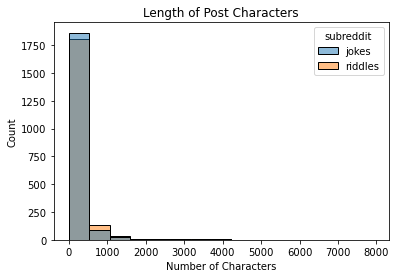

In [14]:
# histogram of word count by subreddit
# plt.figure(figsize = (10,7))
sns.histplot(data = posts_df, x = 'text_length', hue = 'subreddit', bins = 15)
plt.title('Length of Post Characters')
plt.xlabel('Number of Characters')
plt.savefig('./images/string_length', dpi = 99)

;

''

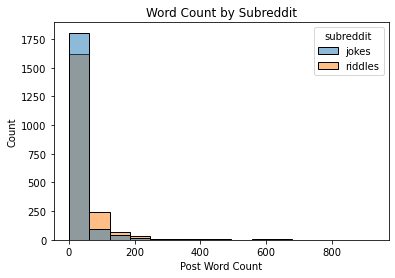

In [15]:
#histogram of word count by subreddit
# plt.figure(figsize = (10,7))
sns.histplot(data = posts_df, x = 'text_word_count', hue = 'subreddit', bins = 15)
plt.title('Word Count by Subreddit')
plt.xlabel('Post Word Count')
plt.savefig('./images/word_count', dpi = 99)

;

In [16]:
posts_df[posts_df['text_word_count'] < 50].shape[0] / posts_df.shape[0]

0.8142857142857143

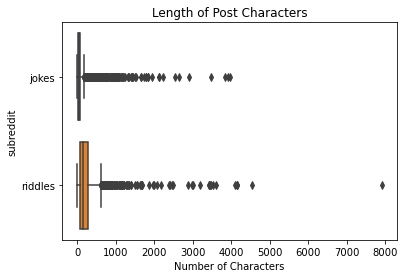

In [17]:
#boxplot of post length count by subreddit
sns.boxplot(data = posts_df, x = 'text_length', y = 'subreddit')
plt.title('Length of Post Characters')
plt.xlabel('Number of Characters')
plt.savefig('./images/string_length_box', dpi = 99);

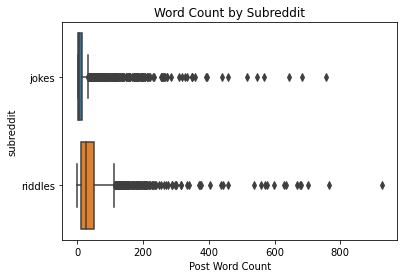

In [18]:
#boxplot of word count by subreddit
sns.boxplot(data = posts_df, x = 'text_word_count', y = 'subreddit')
plt.title('Word Count by Subreddit')
plt.xlabel('Post Word Count')
plt.savefig('./images/word_count_box', dpi = 99);

Through EDA I have shown that the riddles subbreddit uses more words and longer posts on average compared with the jokes subreddit. I dove deeper into the distributions of word count in both categories. They both have a similar distribution as seen in the histograms with over 81% of posts having less than 50 words. The box plots show that there are a lot of outliers when considering word count and length of post. The jokes subreddit goes up to 755 words and 3,962 characters. The riddles subreddit goes up to 926 words and 7,917 characters.

### Feature Selection

In [19]:
# Testing X value as the title column
X_title = posts_df['title']
y_title = posts_df['subreddit']

pipe_title = make_pipeline(CountVectorizer(), LogisticRegression(max_iter = 1000))

pipe_title.fit(X_title, y_title)
pipe_title.score(X_title, y_title)

0.9706766917293234

In [20]:
# Testing X value as the selftext column
X_post = posts_df['selftext']
y_post = posts_df['subreddit']

pipe_post = make_pipeline(CountVectorizer(), LogisticRegression(max_iter = 1000))

pipe_post.fit(X_post, y_post)
pipe_post.score(X_post, y_post)

0.9488721804511279

I want to make the project a little bit harder for myself, so I will be using the post text instead of the title text.

In [21]:
# define X and y - using text of post to determine subreddit category
X = posts_df['selftext']
y = posts_df['subreddit']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)

In [23]:
y.value_counts(normalize = True)

riddles    0.500752
jokes      0.499248
Name: subreddit, dtype: float64

My baseline accuracy is 50%.

### Pipeline and Grid Search to find best features in Logistic Regression

In [24]:
pipe_test = make_pipeline(CountVectorizer(), LogisticRegression(max_iter = 1000))

In [25]:
gs = GridSearchCV(pipe_test,
                  param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
                                'countvectorizer__stop_words': [None, 'english'],
                                'countvectorizer__max_features': [500, 1000, 1500, 2000, 2500],
                                'logisticregression__C': [0.01, 0.1, 1, 10]},
                  verbose=2,
                  n_jobs = -1)

In [26]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [500, 1000, 1500,
                                                           2000, 2500],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (3, 3)],
                         'countvectorizer__stop_words': [None, 'english'],
                         'logisticregression__C': [0.01, 0.1, 1, 10]},
             verbose=2)

In [27]:
gs.best_params_

{'countvectorizer__max_features': 2500,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': None,
 'logisticregression__C': 1}

In [28]:
gs.best_score_

0.8506099910106588

In [29]:
pd.DataFrame(gs.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
138,0.934311,0.011693,0.093743,0.009882,2500,"(1, 2)",None,1,"{'countvectorizer__max_features': 2500, 'count...",0.828047,0.848080,0.856187,0.866221,0.854515,0.850610,0.012693,1
130,0.431224,0.012497,0.053119,0.007657,2500,"(1, 1)",None,1,"{'countvectorizer__max_features': 2500, 'count...",0.823038,0.846411,0.861204,0.859532,0.851171,0.848271,0.013730,2
98,0.512467,0.036171,0.062492,0.000004,2000,"(1, 1)",None,1,"{'countvectorizer__max_features': 2000, 'count...",0.824708,0.851419,0.859532,0.854515,0.851171,0.848269,0.012160,3
106,0.893692,0.030296,0.081242,0.011690,2000,"(1, 2)",None,1,"{'countvectorizer__max_features': 2000, 'count...",0.828047,0.846411,0.854515,0.857860,0.851171,0.847601,0.010484,4
137,0.803070,0.030621,0.096868,0.006252,2500,"(1, 2)",None,0.1,"{'countvectorizer__max_features': 2500, 'count...",0.826377,0.839733,0.849498,0.857860,0.854515,0.845597,0.011392,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.455232,0.008044,0.056667,0.007171,1500,"(3, 3)",english,0.01,"{'countvectorizer__max_features': 1500, 'count...",0.507513,0.509182,0.505017,0.508361,0.510033,0.508021,0.001720,156
124,0.406218,0.022095,0.056247,0.007653,2000,"(3, 3)",english,0.01,"{'countvectorizer__max_features': 2000, 'count...",0.507513,0.509182,0.505017,0.508361,0.510033,0.508021,0.001720,156
156,0.399977,0.015932,0.056241,0.007650,2500,"(3, 3)",english,0.01,"{'countvectorizer__max_features': 2500, 'count...",0.507513,0.509182,0.505017,0.508361,0.510033,0.508021,0.001720,156
60,0.430954,0.019933,0.060965,0.005930,1000,"(3, 3)",english,0.01,"{'countvectorizer__max_features': 1000, 'count...",0.505843,0.509182,0.505017,0.508361,0.510033,0.507687,0.001935,159


Results:
* C is best at the default of 1.0
* Keeping the stop words gives my model a higher accuracy score
* Max features at 2500
* Ngram Range at 1 to 2 words

In [30]:
pipe = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features = 2500), LogisticRegression(max_iter = 1000))

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=2500, ngram_range=(1, 2))),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [32]:
pipe.score(X_train, y_train)

0.9428475935828877

In [33]:
pipe.score(X_test, y_test)

0.8507014028056112

Good score on train and test, but model looks a little overfit. Could be improved.

In [34]:
#testing Tfidf Vectorizer instead of Count Vectorizer

pipe_test2 = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter = 1000))

In [35]:
gs2 = GridSearchCV(pipe_test2,
                  param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                                'tfidfvectorizer__stop_words': [None, 'english'],
                                'tfidfvectorizer__max_features': [500, 1000, 1500, 2000, 2500],
                                'logisticregression__C': [0.01, 0.1, 1, 10]},
                  verbose=2,
                  n_jobs = -1)

In [36]:
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10],
                         'tfidfvectorizer__max_features': [500, 1000, 1500,
                                                           2000, 2500],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2)],
                         'tfidfvectorizer__stop_words': [None, 'english']},
             verbose=2)

In [37]:
gs2.best_params_

{'logisticregression__C': 10,
 'tfidfvectorizer__max_features': 2000,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__stop_words': None}

In [38]:
gs2.best_score_

0.8449238139373871

About the same, a little worse.

#### Final Logistic Regression Model

In [39]:
nlp = spacy.load('en_core_web_sm')
def lemmatized(sentence):
    
    """Function to lemmatize words before fitting into pipeline."""
    
    doc = nlp(sentence)
    return [token.lemma_ for token in doc]

In [40]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features = 2500, tokenizer = lemmatized), LogisticRegression(max_iter = 1000))

In [41]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=2500, ngram_range=(1, 2),
                                 tokenizer=<function lemmatized at 0x000001C72C0B4280>)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [42]:
pipe2.score(X_train, y_train)

0.9512032085561497

In [43]:
pipe2.score(X_test, y_test)

0.8797595190380761

Slight improvement with lemmatization, but takes a long time to run.

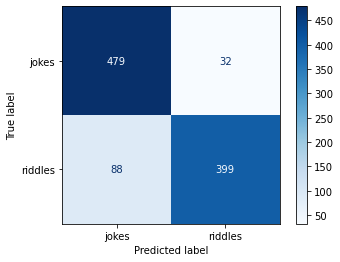

In [44]:
plot_confusion_matrix(pipe2, X_test, y_test, cmap = 'Blues')
plt.savefig('/images/final_confusion_matrix', bbox_inches='tight', dpi = 99)

In [45]:
# find preds
preds = pipe2.predict(X_test)

In [46]:
# view metrics in a table
pd.DataFrame(classification_report(y_test, preds, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
jokes,0.84,0.94,0.89,511.00
riddles,0.93,0.82,0.87,487.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.89,0.88,0.88,998.00
weighted avg,0.88,0.88,0.88,998.00


In [47]:
# make a dataframe of test set identifying which posts my model identified correctly

compare_df = pd.DataFrame(y_test).rename(columns = {'subreddit': 'actuals'})
compare_df['predictions'] = preds
compare_df['compare'] = np.where(compare_df['actuals'] == compare_df['predictions'], True, False)
compare_df

,actuals,predictions,compare
1073,jokes,jokes,True
2511,riddles,riddles,True
3500,riddles,riddles,True
3557,riddles,riddles,True
1202,jokes,jokes,True
...,...,...,...
3839,riddles,riddles,True
1718,jokes,jokes,True
1679,jokes,jokes,True
536,jokes,jokes,True


In [48]:
# add text, length of post and word cout to dataframe

compare_df_text = pd.merge(left = compare_df, right = posts_df[['selftext', 'text_length', 'text_word_count']], left_index = True, right_index = True)
compare_df_text

,actuals,predictions,compare,selftext,text_length,text_word_count
1073,jokes,jokes,True,then i realized i was just beating a dead horse,47,10
2511,riddles,riddles,True,Me can bring tears to your eyes and a smile t...,139,31
3500,riddles,riddles,True,It could be big it could be small but definite...,137,26
3557,riddles,riddles,True,"this brainteaser. As a matter of fact, Smully...",775,133
1202,jokes,jokes,True,He gets horny.,14,3
...,...,...,...,...,...,...
3839,riddles,riddles,True,I turn in endless circles but never become diz...,126,23
1718,jokes,jokes,True,[removed],9,1
1679,jokes,jokes,True,"In space, a hole in the wall would kill everyone.",49,10
536,jokes,jokes,True,And I'm definitely not a monk!,30,6


In [49]:
round(compare_df_text.groupby('compare')[['text_length', 'text_word_count']].describe())

text_length                                                \
              count   mean    std  min   25%   50%    75%     max   
compare                                                             
False         120.0  195.0  760.0  0.0   9.0  40.0  121.0  7917.0   
True          878.0  178.0  319.0  2.0  24.0  71.0  199.0  3593.0   

        text_word_count                                           
                  count  mean   std  min  25%   50%   75%    max  
compare                                                           
False             120.0  29.0  71.0  0.0  1.0   6.0  24.0  577.0  
True              878.0  33.0  60.0  1.0  5.0  14.0  38.0  702.0

No real variations between the correctly and incorectly guessed predictions.

In [50]:
# look at predicted probabilities
pipe2.predict_proba(X_train)

array([[0.79047171, 0.20952829],
       [0.96027231, 0.03972769],
       [0.00330976, 0.99669024],
       ...,
       [0.71866578, 0.28133422],
       [0.84118106, 0.15881894],
       [0.9338739 , 0.0661261 ]])

The probabilities mostly show that my model was confident in the direction of the output.

In [51]:
#look at coefs
coefs = pipe.named_steps['logisticregression'].coef_

In [52]:
#put them in dataframe with words
coef_df = pd.DataFrame({'coefs': coefs[0],
                        'features': pipe['countvectorizer'].get_feature_names()})

''

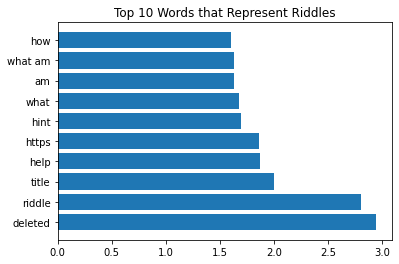

In [53]:
#examine a plot of ten largest (riddles)
largest = coef_df.nlargest(10, 'coefs')
# plt.figure(figsize = (8,5))
plt.barh(data = largest, y = 'features', width = 'coefs')
plt.title('Top 10 Words that Represent Riddles')
plt.savefig('images/riddles_bar', dpi = 99)
;

''

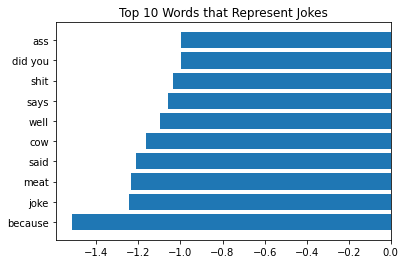

In [54]:
#ten smallest (jokes)
smallest = coef_df.nsmallest(10, 'coefs')
# plt.figure(figsize = (8,5))
plt.barh(data = smallest, y = 'features', width = 'coefs')
plt.title('Top 10 Words that Represent Jokes')
plt.savefig('images/jokes_bar', dpi = 99)
;

I think the top 10 words for each subreddit make sense. There are a few profanities in the jokes, which is to be expected. Riddles often end with questions like "What am I?" or "How many are there?" and that is apparent in the bar chart.

In [55]:
# I pulled a joke from a day that is outside the time range of my data pull to see if my model could classify it correctly
# https://www.reddit.com/r/Jokes/comments/n3pdia/i_once_saw_a_picture_of_mt_rushmore_before_it_was/
pipe.predict(['Its natural beauty was unpresidented'])

array(['jokes'], dtype=object)

In [56]:
# This riddle is from a time outside of my data pull
# https://www.reddit.com/r/riddles/comments/bcpo7n/lose_me_once_ill_come_back_stronger_lose_me_twice/
pipe.predict(['Broke two, cooked two, and ate two. How many do I have left?'])

array(['riddles'], dtype=object)

My model was able to predict the new posts!

### Other Classifier Models

#### Decision Tree

Decision Tree Classifier Scores:
* 10: Train = 0.879, Test = 0.827
* 5: Train = 0.817, Test = 0.809
* 20: Train = 0.938, Test = 0.825
* 30: Train = 0.947, Test = 0.831

In [57]:
pipe3 = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features = 2500, tokenizer = lemmatized), DecisionTreeClassifier(max_depth = 20))

In [58]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=2500, ngram_range=(1, 2),
                                 tokenizer=<function lemmatized at 0x000001C72C0B4280>)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=20))])

In [59]:
pipe3.score(X_train, y_train)

0.9395053475935828

In [60]:
pipe3.score(X_test, y_test)

0.8296593186372746

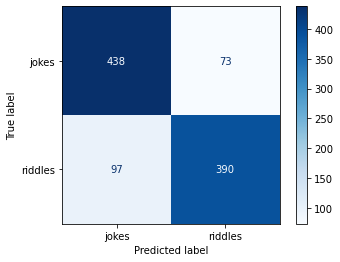

In [61]:
plot_confusion_matrix(pipe3, X_test, y_test, cmap = 'Blues')

In [62]:
# find preds
preds2 = pipe3.predict(X_test)

In [63]:
pd.DataFrame(classification_report(y_test, preds2, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
jokes,0.82,0.86,0.84,511.00
riddles,0.84,0.80,0.82,487.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.83,0.83,0.83,998.00
weighted avg,0.83,0.83,0.83,998.00


Logistic Regression does better on all metrics.

#### Gradient Boosting

In [64]:
X2 = posts_df['selftext']
y2 = y.map({'jokes': 0, 'riddles': 1})

In [65]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 8)

In [66]:
pipe4 = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features = 2500, tokenizer = lemmatized), GradientBoostingClassifier())

In [67]:
pipe4.fit(X2_train, y2_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=2500, ngram_range=(1, 2),
                                 tokenizer=<function lemmatized at 0x000001C72C0B4280>)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [68]:
pipe4.score(X2_train, y2_train)

0.883355614973262

In [69]:
pipe4.score(X2_test, y2_test)

0.8537074148296593

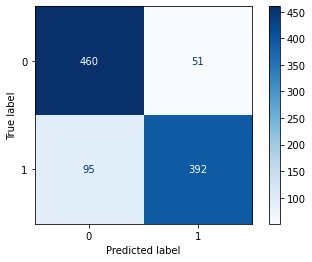

In [70]:
plot_confusion_matrix(pipe4, X2_test, y2_test, cmap = 'Blues')

In [71]:
# find preds
preds3 = pipe4.predict(X2_test)

In [72]:
pd.DataFrame(classification_report(y2_test, preds3, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
0,0.83,0.90,0.86,511.00
1,0.88,0.80,0.84,487.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.86,0.85,0.85,998.00
weighted avg,0.86,0.85,0.85,998.00


#### Naive Bayes Model

In [73]:
pipe5 = make_pipeline(CountVectorizer(ngram_range=(1, 2), max_features = 2500, tokenizer = lemmatized), MultinomialNB())

In [74]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=2500, ngram_range=(1, 2),
                                 tokenizer=<function lemmatized at 0x000001C72C0B4280>)),
                ('multinomialnb', MultinomialNB())])

In [75]:
pipe5.score(X_train, y_train)

0.8198529411764706

In [76]:
pipe5.score(X_test, y_test)

0.8006012024048096

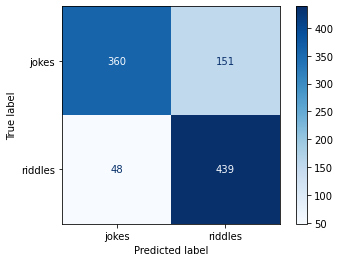

In [77]:
plot_confusion_matrix(pipe5, X_test, y_test, cmap = 'Blues')

### Conclusions and Recommendations

My final Logistic Regression model with Lemmatization and CountVectorizer has proved to be the highest scoring on all metrics. Overall, I am impressed with the performance of my model and believe the classification metrics prove it is working well.

I have some recommendations I think would improve my model or would be interesting to look into:
* Using both the title and text columns as features would have probably helped my model, but would have taken a very long time.
    * Many of the posts use the title to start the joke or riddle, and the body of the post is only part of it.
* Also pulling the comments would probably really improve the model.


There are a few areas where I think some more data cleaning would have been helpful:
* Some show up as deleted or removed, and it might be beneficial to take them out of the train set.
* A lot of the riddles were links to non-reddit sources. In some ways this helped me identify them as riddles, but it would interesting to see what removing links does.
